In [1]:
using JuMP
using HiGHS
using Plots

# Example 2 - Multi-stage production planning

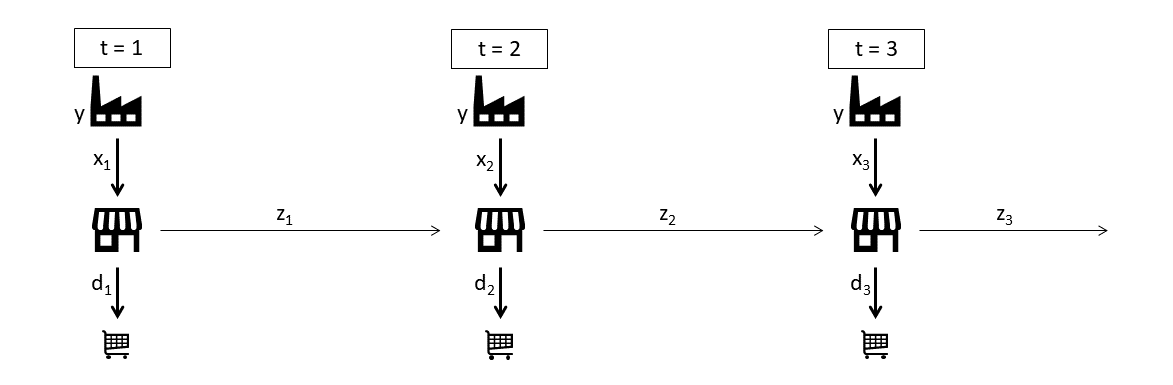

We consider a production planning setting in which the production capacity is ordered in advance. 

The logic is the following:
1. We must request a capacity of $y$ to be available for the next $T$ periods at a cost of $v$ per unit ordered.
2. In each period, we may transfer $x$ unit from the maximum capacity $y$ at a cost $c$ per unit or use the amount in inventory $z$ to satisfy the demand
3. Any amount held in stock costs $h$ per unit per period.

Our objective is to satisfy the *uncertain* demand $d$ at minimum cost. A two-stage model of our problem can be formulated as follows.

Let:
- $t \in T$ - periods
- $s \in S$ - scenarios
- $y$ - capacity
- $x_{t,s}$ - transfer in each period $t$ and scenario $s$
- $z_{t,s}$ - total in storage in period $t$, scenario $s$
- $p_s$ - probability of scenario $s$
- $d_{t,s}$ - demand in period $t$, scenario $s$    

Our two-stage model is given by

\begin{align*}
    \min~ & vy + \sum_{s \in S} p_s \left(\sum_{t\in T} 
        c_t x_{t,s} + h_t z_{t,s}\right) \\
    \text{s.t.:}~ &  z_{t,s} = z_{t-1,s} + x_{t,s} - d_{t,s}, \ \forall t \in T, s \in S \\
    &  x_{t,s} \le y, \ \forall t \in T, s \in S.
\end{align*}

Below we set the input data. Notice we consider 4 scenarios and 3 periods.

In [2]:
# Data
T = [1,2,3]        # periods 
S = [1,2,3,4]      # scenarios
c = [5, 4, 6]      # unit cost
h = [1, 1.5, 1]    # storage cost
d = [10 10 10 10;  # demand[t,s]
     14 14 16 16;
     16 18 18 22] 
z₀ = 5             # initial inventory
v = 2              # unit cost 
p = [0.3, 0.3, 0.22, 0.18]; # probabilities

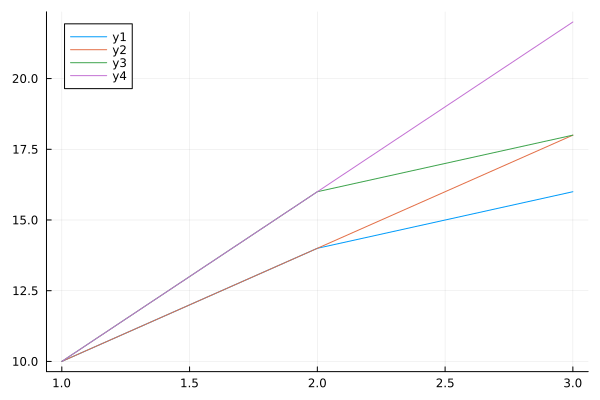

In [3]:
plot(d)

In [4]:
# Implementing the model
m = Model(HiGHS.Optimizer)
set_silent(m)

@variables(m, 
    begin
        y ≥ 0               # order
        z[t ∈ T, s ∈ S] ≥ 0 # storage
        x[t ∈ T, s ∈ S] ≥ 0 # allocation
    end
)

@objective(m, Min, 
        v * y + sum(p[s] * (
            sum(c[t] * x[t,s] + h[t] * z[t,s] for t ∈ T))
        for s ∈ S)
)

# Material balance t = 1
@constraint(m, [t ∈ T, s ∈ S; t == 1], 
    z[t,s] == z₀ + x[t,s] - d[t,s]    
)

# Material balance t > 1
@constraint(m, [t ∈ T, s ∈ S; t > 1], 
    z[t,s] == z[t-1,s] + x[t,s] - d[t,s]    
)

# Use only what ordered
@constraint(m, [t ∈ T, s ∈ S],  
    y ≥ x[t,s]
)

optimize!(m);

In [5]:
order_2s = round.(value.(y),digits=2)       # Total ordered
storage_2s = round.(value.(z),digits=2)     # Inventory
production_2s = round.(value.(x),digits=2)  # Production
obj_2s = objective_value(m)

println("order_2s = ", order_2s)
println("obj = ", obj_2s)
for s in S
    println("scenario: ", s)
    println("   storage_2s = ",[storage_2s[t,s] for t in T])
    println("   production_2s = ",[production_2s[t,s] for t in T])
end   

order_2s = 16.0
obj = 226.60000000000002
scenario: 1
   storage_2s = [0.0, 2.0, 0.0]
   production_2s = [5.0, 16.0, 14.0]
scenario: 2
   storage_2s = [0.0, 2.0, 0.0]
   production_2s = [5.0, 16.0, 16.0]
scenario: 3
   storage_2s = [2.0, 2.0, 0.0]
   production_2s = [7.0, 16.0, 16.0]
scenario: 4
   storage_2s = [6.0, 6.0, 0.0]
   production_2s = [11.0, 16.0, 16.0]


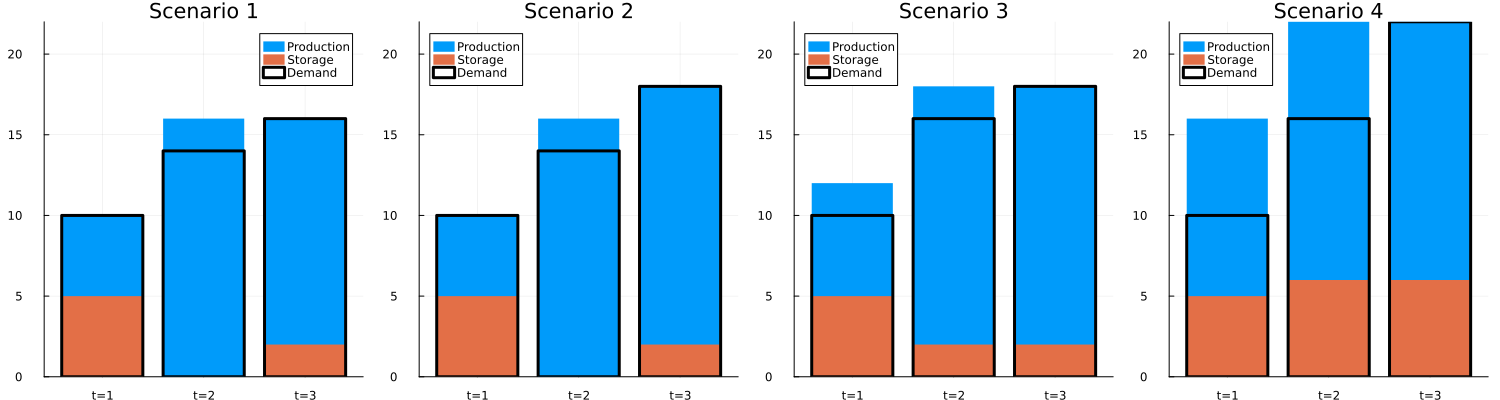

In [6]:
# Plot
periods = ["t=1", "t=2", "t=3"]
storage_2s_w0 = vcat(transpose(fill(z₀, length(S))), storage_2s)
plots = []
for s in S
    p = bar(periods, [production_2s[t,s]+storage_2s_w0[t,s] for t in T], label="Production", title="Scenario $(s)",linecolor=false)
        bar!(periods, [storage_2s_w0[t,s] for t in T], stack=true, label="Storage",linecolor=false)
        bar!(periods, [d[t,s] for t in T], stack=true, label="Demand", fillalpha=0.,linewidth=3)
    push!(plots, p)
end
plot(plots..., layout=(1,length(S)),size=(1500,400),link=:y)

The solution above has an issue related to dynamics, and how information is revealed. In particular, notice how for each scenario, the process happens with *perfect knowledge of the demand realisations for that scenario*.

To be truly adherent to how information is acquired, we must impose to the model constraints that prevent scenarios to be anticipated.

These nonanticipativity conditions must impose the following: if at a given stage two scenarios $s, s' \in S : s \neq s'$ are indicernible, then we must enforce that
\begin{align*}
    x_{t,s} & = x_{t,s'} \\
    s_{t,s} & = s_{t,s'}.
\end{align*}

These conditions are called *nonanticipative conditions*. These play a crucial role on the structure of multi-stage problems. 

Let us revisit our scenario structure. Suppose it can be structured as the figure on the left. We start with a known demand of 10, then we have two scenarios, which then open into two other scenarios.

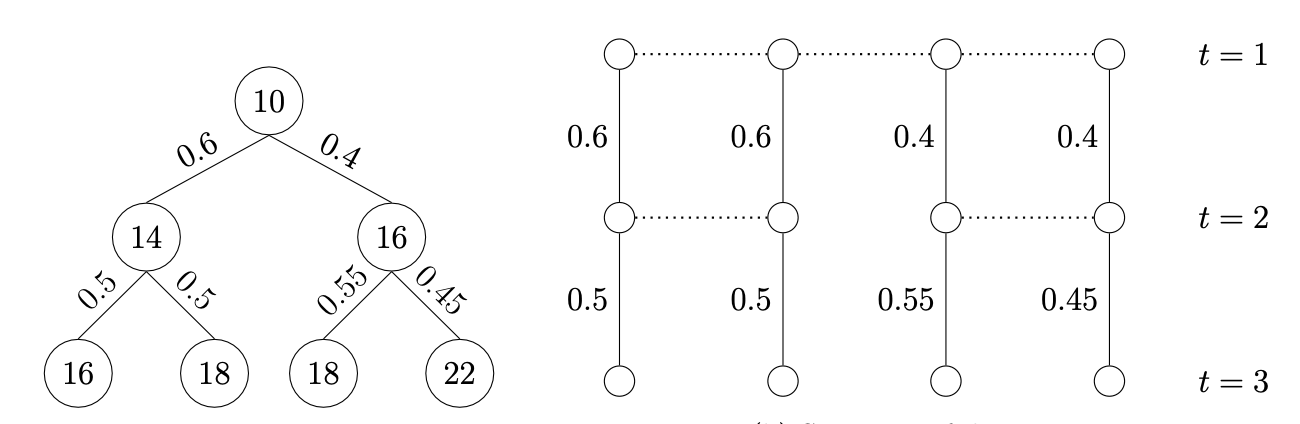

The figure on the right shows the NAC structure representing the information acquisition dynamics. The dashed lines represent the NACs that must be imposed to faithfully represent it.

One alternative to model the NACs is simply to represent via a parameter which scenarios pairs must be linked by NACs in each stage.

That is, we consider the matrix $NAC_{|T| \times |S| \times |S|}$ where $NAC_{t,s,s'} = 1$ if $s$ and $s'$ are indiscernible in stage $t$.

In [7]:
NAC = zeros(3,4,4)
NAC[1,:,:] = [1 1 1 1;
              0 1 0 0;
              0 0 1 0;
              0 0 0 1]

NAC[2,:,:] = [1 1 0 0;
              0 1 0 0;
              0 0 1 1;
              0 0 0 1]

NAC[3,:,:] = [1 0 0 0;
              0 1 0 0;
              0 0 1 0;
              0 0 0 1];

Some remarks about the NAC matrices:
- Notice that, in reality we only need one of the triangular sections, not including the main diagonal;
- NACs are "wasteful" by definition, since it would be more memory efficient to apply substitution for all linked variables.

In [8]:
# s2 ∈ setdiff(S,[1:s1]) <=> s2 ∈ {s1+1,...,S}
@constraint(m, NAC_x[t ∈ T, s1 ∈ S, s2 ∈ setdiff(S,[1:s1]); NAC[t,s1,s2] == 1],
    x[t,s1] == x[t,s2]
)

@constraint(m, NAC_z[t ∈ T, s1 ∈ S, s2 ∈ setdiff(S,[1:s1]); NAC[t,s1,s2] == 1],
    z[t,s1] == z[t,s2]
);

In [9]:
print(1,m)

1Min 2 y + 1.5 x[1,1] + 0.3 z[1,1] + 1.2 x[2,1] + 0.44999999999999996 z[2,1] + 1.7999999999999998 x[3,1] + 0.3 z[3,1] + 1.5 x[1,2] + 0.3 z[1,2] + 1.2 x[2,2] + 0.44999999999999996 z[2,2] + 1.7999999999999998 x[3,2] + 0.3 z[3,2] + 1.1 x[1,3] + 0.22 z[1,3] + 0.88 x[2,3] + 0.33 z[2,3] + 1.32 x[3,3] + 0.22 z[3,3] + 0.8999999999999999 x[1,4] + 0.18 z[1,4] + 0.72 x[2,4] + 0.27 z[2,4] + 1.08 x[3,4] + 0.18 z[3,4]
Subject to
 z[1,1] - x[1,1] = -5
 z[1,2] - x[1,2] = -5
 z[1,3] - x[1,3] = -5
 z[1,4] - x[1,4] = -5
 -z[1,1] + z[2,1] - x[2,1] = -14
 -z[1,2] + z[2,2] - x[2,2] = -14
 -z[1,3] + z[2,3] - x[2,3] = -16
 -z[1,4] + z[2,4] - x[2,4] = -16
 -z[2,1] + z[3,1] - x[3,1] = -16
 -z[2,2] + z[3,2] - x[3,2] = -18
 -z[2,3] + z[3,3] - x[3,3] = -18
 -z[2,4] + z[3,4] - x[3,4] = -22
 NAC_x[1,1,1] : 0 = 0
 NAC_x[1,1,2] : x[1,1] - x[1,2] = 0
 NAC_x[1,1,3] : x[1,1] - x[1,3] = 0
 NAC_x[1,1,4] : x[1,1] - x[1,4] = 0
 NAC_x[1,2,2] : 0 = 0
 NAC_x[1,3,3] : 0 = 0
 NAC_x[1,4,4] : 0 = 0
 NAC_x[2,1,1] : 0 = 0
 NAC_x[2,1,

In [10]:
optimize!(m)

order_3s = round.(value.(y),digits=2)       # Total ordered
storage_3s = round.(value.(z),digits=2)     # Inventory
production_3s = round.(value.(x),digits=2)  # Production
obj_3s = objective_value(m)

println("order_3s = ", order_3s)
println("obj = ", obj_3s)
println("Difference 3s - 2s:", round(obj_3s - obj_2s, digits =2))
for s in S
    println("scenario: ", s)
    println("   storage_3s = ",[storage_3s[t,s] for t in T])
    println("   production_3s = ",[production_3s[t,s] for t in T])
end

order_3s = 19.0
obj = 228.82
Difference 3s - 2s:2.22
scenario: 1
   storage_3s = [0.0, 5.0, 0.0]
   production_3s = [5.0, 19.0, 11.0]
scenario: 2
   storage_3s = [0.0, 5.0, 0.0]
   production_3s = [5.0, 19.0, 13.0]
scenario: 3
   storage_3s = [-0.0, 3.0, 0.0]
   production_3s = [5.0, 19.0, 15.0]
scenario: 4
   storage_3s = [-0.0, 3.0, 0.0]
   production_3s = [5.0, 19.0, 19.0]


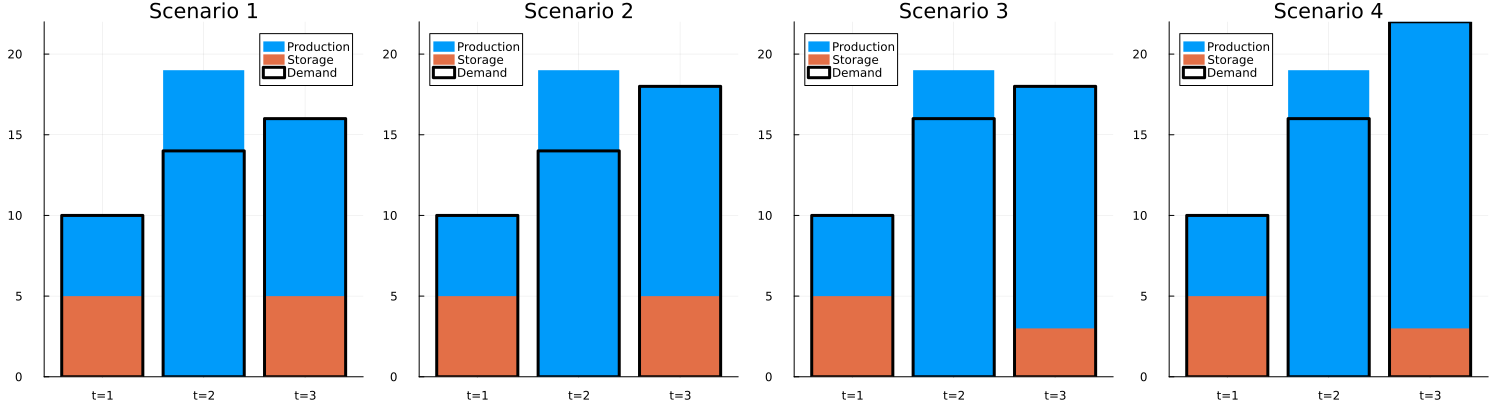

In [11]:
# Plot
periods = ["t=1", "t=2", "t=3"]
storage_3s_w0 = vcat(transpose(fill(z₀, length(S))), storage_3s)
plots = []
for s in S
    p = bar(periods, [production_3s[t,s]+storage_3s_w0[t,s] for t in T], label="Production", title="Scenario $(s)",linecolor=false)
        bar!(periods, [storage_3s_w0[t,s] for t in T], stack=true, label="Storage",linecolor=false)
        bar!(periods, [d[t,s] for t in T], stack=true, label="Demand", fillalpha=0.,linewidth=3)
    push!(plots, p)
end
plot(plots..., layout=(1,length(S)),size=(1500,400),link=:y)

Notice that:
- The 2-stage version in this case is not a good approximation for the first-stage decision, as $y$ changes in value
- Also, cost is underestimated, which might be an issue depending on the application. 